<div dir='rtl'>
<h2> K-means vs GMM (۳۰ نمره)</h2> 


---


در این تمرین قصد داریم دو روش 
kmeans 
و 
GMM
را بدون استفاده از کتابخانه‌های آماده پیاده‌سازی کنیم. 

برای پیاده‌سازی GMM
می‌توانید از تابع نرمال چند متغیره که در 
<code> scipy </code>
است، استفاده کنید.

</div>

<div dir='rtl'>

برای پیاده‌سازی الگوریتم 
K-means
کار را تا جایی ادامه دهید که مرکز خوشه‌ها تغییر نکند.

در پیاده‌سازی الگوریتم GMM
هم تا جایی پیش‌بروید که تفاوت درست‌نمایی در دو دور متوالی کمتر از ۰.۱ باشد.

</div>

In [76]:
import numpy as np

def find_distance(x, y):

    k = y.shape[0]
    data_size = x.shape[0]

    x_norm = np.repeat(np.expand_dims(np.linalg.norm(x, axis = 1) ** 2, 1), k, axis = 1)
    y_norm = np.repeat(np.expand_dims(np.linalg.norm(y, axis = 1) ** 2, 0), data_size, axis = 0)
    x_y_inner = np.matmul(x, y.T)

    o = x_norm + y_norm - 2 * x_y_inner
    return o



class Kmeans:

    def __init__(self, x, k, max_iters = 1000):
        self.x = x
        self.data_size = x.shape[0]
        self.feature_size = x.shape[1]
        self.k = k
        self.max_iters = max_iters

        self.centers = np.zeros((k, x.shape[1]))

        self.predictions = np.zeros(self.data_size)


    def random_init(self):
        mean = np.mean(self.x, axis = 0)
        std = np.std(self.x, axis = 0)

        centers = np.random.randn(self.k, self.feature_size) * mean + std

        return centers


    def predict(self):
        
        self.centers = self.random_init()

        for i in range(self.max_iters):
            data_center_dists = find_distance(self.x, self.centers)
            self.predictions = data_center_dists.argmin(axis = 1)

            prev_centers = np.copy(self.centers)

            for j in range(self.k):
                cluster_j = self.x[self.predictions == j] 
                if len(cluster_j) > 0:
                    self.centers[j] = cluster_j.mean(axis = 0)

            if (prev_centers == self.centers).all():
                return

            
    def calc_cost(self):
        cost = 0

        for i in range(self.k):
            cluster_x = self.x[self.predictions == i]
            cluster_center = self.centers[i]
            if len(cluster_x) > 0:
                cluster_distances = find_distance(cluster_x, np.expand_dims(cluster_center, 0))

            cost += cluster_distances.sum()
    
        return cost 

    
    def get_cooccurrence_matrix(self, _y, show=False):    
        cooccurrence_matrix = np.array([[0 for i in range(self.k)] for j in range(self.k)])
        for i in range(len(_y)):
            cooccurrence_matrix[_y[i]][self.predictions[i]] += 1
        
        if show:
            df = pd.DataFrame(cooccurrence_matrix, columns=['Cluster ' + str(i) for i in range(self.k)], 
                              index=['Class ' + str(i) for i in range(self.k)])
            print(df)
            
        return cooccurrence_matrix
    

def best_K_Means(X, k, n_run=10):
    model = Kmeans(X, k)
    model.predict()
    k_means_model = model
    best_score = get_purity(model, Y) + get_rand_index(model, Y)
    for i in range(n_run):
        model = Kmeans(X, 2)
        model.predict()
        score = get_purity(model, Y) + get_rand_index(model, Y)
        if score > best_score:
            k_means_model = model
            best_score = score
            
    return k_means_model


In [7]:
from scipy.stats import multivariate_normal as mvn

class GMM:
    def __init__(self, C, max_iters = 30):
        self.C = C # number of Guassians/clusters
        self.max_iters = max_iters
        
    def calculate_mean_covariance(self, X, prediction):
        d = X.shape[1]
        labels = np.unique(prediction)
        self.initial_means = np.zeros((self.C, d))
        self.initial_cov = np.zeros((self.C, d, d))
        self.initial_pi = np.zeros(self.C)
        
        counter=0
        for label in labels:
            ids = np.where(prediction == label) # returns indices
            self.initial_pi[counter] = len(ids[0]) / X.shape[0]
            self.initial_means[counter,:] = np.mean(X[ids], axis = 0)
            de_meaned = X[ids] - self.initial_means[counter,:]
            Nk = X[ids].shape[0] # number of data points in current gaussian
            self.initial_cov[counter,:, :] = np.dot(self.initial_pi[counter] * de_meaned.T, de_meaned) / Nk
            counter+=1
        assert np.sum(self.initial_pi) == 1    
            
        return (self.initial_means, self.initial_cov, self.initial_pi)
    
    def _initialise_parameters(self, X):
        k = self.C
        kmeans = best_K_Means(X, k)
        prediction = kmeans.predictions
        self._initial_means, self._initial_cov, self._initial_pi = self.calculate_mean_covariance(X, prediction)
        
        return (self._initial_means, self._initial_cov, self._initial_pi)
    
    def _e_step(self, X, pi, mu, sigma):
        N = X.shape[0] 
        self.gamma = np.zeros((N, self.C))

        const_c = np.zeros(self.C)
        
        self.mu = self.mu if self._initial_means is None else self._initial_means
        self.pi = self.pi if self._initial_pi is None else self._initial_pi
        self.sigma = self.sigma if self._initial_cov is None else self._initial_cov

        for c in range(self.C):
            # Posterior Distribution using Bayes Rule
            self.gamma[:,c] = self.pi[c] * mvn.pdf(X, self.mu[c,:], self.sigma[c])

        # normalize across columns to make a valid probability
        gamma_norm = np.sum(self.gamma, axis=1)[:,np.newaxis]
        self.gamma /= gamma_norm

        return self.gamma
    
    def _m_step(self, X, gamma):
        N = X.shape[0] # number of objects
        C = self.gamma.shape[1] # number of clusters
        d = X.shape[1] # dimension of each object

        # responsibilities for each gaussian
        self.pi = np.mean(self.gamma, axis = 0)

        self.mu = np.dot(self.gamma.T, X) / np.sum(self.gamma, axis = 0)[:,np.newaxis]

        for c in range(C):
            x = X - self.mu[c, :] # (N x d)
            
            gamma_diag = np.diag(self.gamma[:,c])
            x_mu = np.matrix(x)
            gamma_diag = np.matrix(gamma_diag)

            sigma_c = x.T * gamma_diag * x
            self.sigma[c,:,:]=(sigma_c) / np.sum(self.gamma, axis = 0)[:,np.newaxis][c]

        return self.pi, self.mu, self.sigma
    
    
    def _compute_loss_function(self, X, pi, mu, sigma):
        N = X.shape[0]
        C = self.gamma.shape[1]
        self.loss = np.zeros((N, C))

        for c in range(C):
            dist = mvn(self.mu[c], self.sigma[c],allow_singular=True)
            self.loss[:,c] = self.gamma[:,c] * (np.log(self.pi[c]+0.00001)+dist.logpdf(X)
                                                -np.log(self.gamma[:,c]+0.000001))
        self.loss = np.sum(self.loss)
        return self.loss
    
    def fit(self, X):
        self.X = X
        d = X.shape[1]
        self.mu, self.sigma, self.pi =  self._initialise_parameters(X)
        
        pre_loss = float('inf')
        
        try:
            for run in range(self.max_iters):  
                self.gamma  = self._e_step(X, self.mu, self.pi, self.sigma)
                self.pi, self.mu, self.sigma = self._m_step(X, self.gamma)
                loss = self._compute_loss_function(X, self.pi, self.mu, self.sigma)
                
#                 if run % 10 == 0:
#                     print("Iteration: %d Loss: %0.6f" %(run, loss))
                    
                if abs(loss - pre_loss) < 0.1:
                    return self
                pre_loss = loss

        
        except Exception as e:
            print(e)
        
        return self
    
    
    def predict(self, X):
        labels = np.zeros((X.shape[0], self.C))
        
        for c in range(self.C):
            labels [:,c] = self.pi[c] * mvn.pdf(X, self.mu[c,:], self.sigma[c])
        labels  = labels.argmax(1)
        return labels 
    
    def predict_proba(self, X):
        post_proba = np.zeros((X.shape[0], self.C))
        
        for c in range(self.C):
            # Posterior Distribution using Bayes Rule
            post_proba[:,c] = self.pi[c] * mvn.pdf(X, self.mu[c,:], self.sigma[c])
    
        return post_proba
    
    def get_cooccurrence_matrix(self, _y, show=False):    
        cooccurrence_matrix = np.array([[0 for i in range(self.C)] for j in range(self.C)])
        predictions = self.predict(self.X)
        for i in range(len(_y)):
            cooccurrence_matrix[_y[i]][predictions[i]] += 1
        
        if show:
            df = pd.DataFrame(cooccurrence_matrix, columns=['Cluster ' + str(i) for i in range(self.C)], 
                              index=['Class ' + str(i) for i in range(self.C)])
            print(df)
            
        return cooccurrence_matrix
    

<div dir='rtl'>
<h4> الف (۲۰ نمره)</h4>

با استفاده از تابع زیر دیتاست را ایجاد کنید. سپس برای
K=2
دو الگوریتم را روی دیتاست اجرا کنید. 

کیفیت روش‌های پیاده‌سازی شده را با استفاده از دو معیار 
<code> purity </code>
و 
<code> rand-index </code>
با یکدیگر مقایسه کنید.


---


در روش K-means
بهتر است اجرا چند بار انجام شود و بهترین نتیجه گزارش شود.
</div>

In [8]:
from sklearn.datasets import make_classification
X, Y = make_classification(n_samples=700, n_features=2,
                           n_informative=2, n_redundant=0,
                           n_classes=2)

In [9]:
def get_purity(model, Y):
    cooccurrence_matrix = model.get_cooccurrence_matrix(Y)
    return sum(cooccurrence_matrix.max(0)) / len(Y)


def choose2(a):
    if a < 2:
        return 0
    return a * (a - 1) / 2

vComb = np.vectorize(choose2)

def get_rand_index(model, Y):
    cooccurrence_matrix = model.get_cooccurrence_matrix(Y)
    tp_plus_fp = vComb(cooccurrence_matrix.sum(0)).sum()
    tp_plus_fn = vComb(cooccurrence_matrix.sum(1)).sum()
    tp = vComb(cooccurrence_matrix).sum()
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = choose2(cooccurrence_matrix.sum()) - tp - fp - fn

    return float(tp + tn) / (tp + fp + fn + tn)

In [10]:
k_means_model = best_K_Means(X, 2)
print("-> K-Means:")
print("   Purity: ", get_purity(k_means_model, Y))
print("   Rand-index:", get_rand_index(k_means_model, Y))

gmm_model = GMM(2)
gmm_model.fit(X)
predicted_values = gmm_model.predict(X)
print("-> GMM:")
print("   Purity: ", get_purity(gmm_model, Y))
print("   Rand-index:", get_rand_index(gmm_model, Y))

-> K-Means:
   Purity:  0.8657142857142858
   Rand-index: 0.767161250766401
-> GMM:
   Purity:  0.8628571428571429
   Rand-index: 0.7629920294297977


<div dir='rtl'>
    تقریبا مشابه عمل می‌کنند. معیار 
    purity 
    برای هر دو بهتر از 
    rand-index
    است.
</div>

<div dir='rtl'>
<h3>ب (۱۰ نمره)</h3>

با استفاده از دستورات زیر دیتاست جدید ایجاد کنید. سپس الگوریتم‌های 
Kmeans
و 
GMM
را روی آن‌ها اجرا کنید

در نهایت نتیجه‌ی خوشه‌بندی را بصری‌سازی کنید و نتایج بدست آمده را با هم مقایسه نمایید.


---

برای بصری‌سازی می‌توانید از کتابخانه‌های آماده استفاده کنید.
</div>

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=2, rseed=0, ax=None):
    labels = kmeans.predictions
    
    

    # plot the input data
    ax = ax or plt.gca()
#     ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.centers
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
    
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
    
def plot_gmm(gmm, X, label=True, ax=None):
#     plt.figure(figsize = (10,8))
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    
    # # compute centers as point of highest density of distribution
    centers = np.zeros((2,2))
    for i in range(gmm.C):
        density = mvn(cov=gmm.sigma[i], mean=gmm.mu[i]).logpdf(X)
        centers[i, :] = X[np.argmax(density)]
    
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis', zorder=2)

        plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.5, zorder=5);
        
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
#     ax.axis('equal')
    
    w_factor = 0.2 / gmm.pi.max()
    for pos, covar, w in zip(gmm.mu, gmm.sigma, gmm.pi):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    
    

In [16]:
from sklearn.datasets.samples_generator import make_moons
X, Y = make_moons(n_samples=700, noise=0.2)

-> K-Means:
   Purity:  0.7485714285714286
   Rand-index: 0.6230369916206826
-> GMM:
   Purity:  0.8442857142857143
   Rand-index: 0.7366891477621091


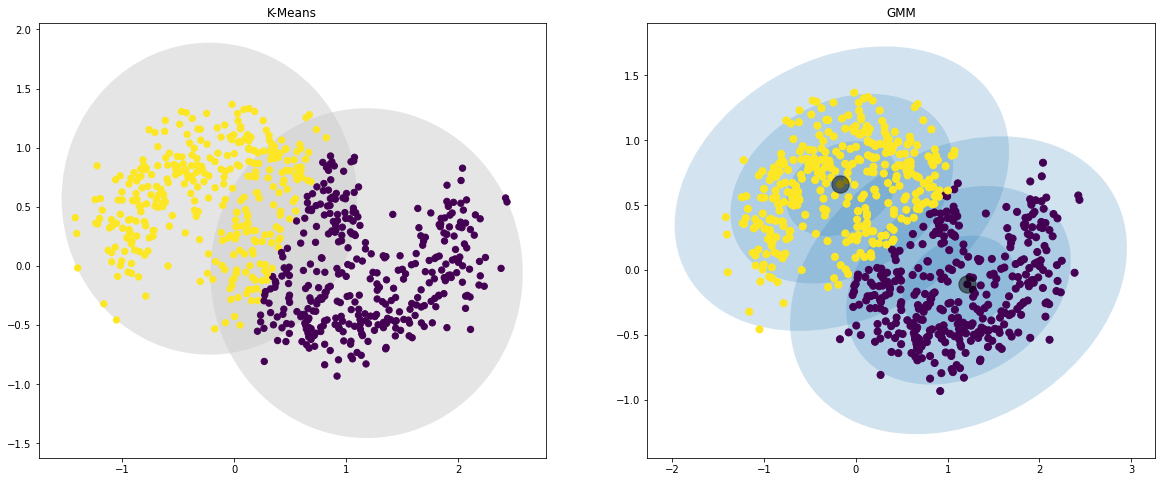

In [17]:
fig = plt.figure(figsize = (20,8))

k_means_model = best_K_Means(X, 2)
print("-> K-Means:")
print("   Purity: ", get_purity(k_means_model, Y))
print("   Rand-index:", get_rand_index(k_means_model, Y))
ax = fig.add_subplot(1,2,1)
ax.set_title("K-Means")
plot_kmeans(k_means_model, X, ax=ax)

gmm_model = GMM(2)
gmm_model.fit(X)
predicted_values = gmm_model.predict(X)
print("-> GMM:")
print("   Purity: ", get_purity(gmm_model, Y))
print("   Rand-index:", get_rand_index(gmm_model, Y))
ax = fig.add_subplot(1,2,2)
ax.set_title("GMM")
plot_gmm(gmm_model, X, ax=ax)

<div dir='rtl'>
با توجه به وجود نویز در داده، عملکرد
GMM
تا حدودی بهتر است.
    همچنین در کل الگوریتم 
    k-means
    برای خوشه‌هایی با شکل دلخواه خوب عمل نمی‌کند مگر اینکه فاصله‌ی کلاستر‌ها از هم زیاد باشد. که در اینجا اینطور نیست.
    </div>

In [18]:
from sklearn.datasets.samples_generator import make_circles
X, Y = make_circles(n_samples=700, noise=0.2)

-> K-Means:
   Purity:  0.5171428571428571
   Rand-index: 0.4998732883711424
-> GMM:
   Purity:  0.51
   Rand-index: 0.4994849785407725


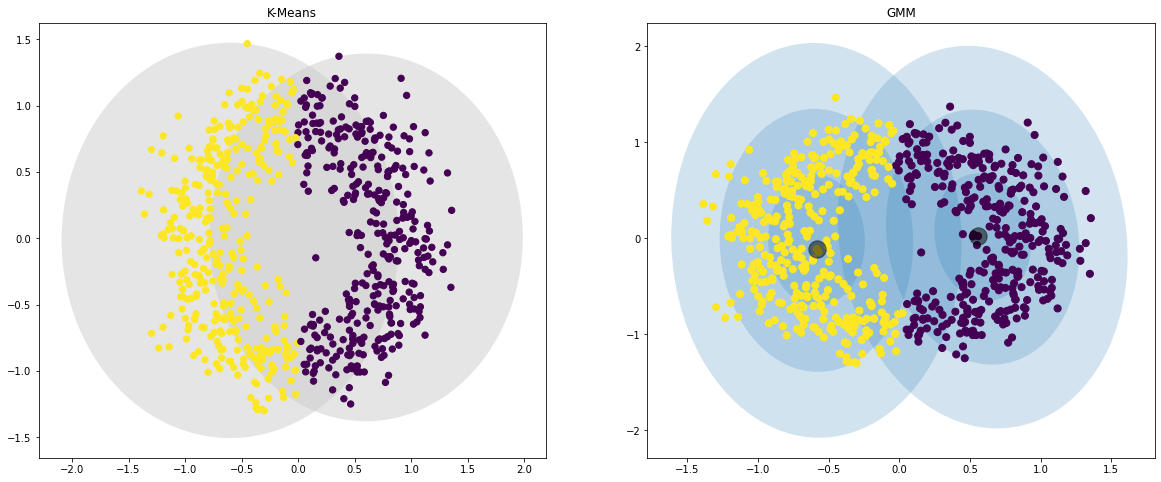

In [19]:
fig = plt.figure(figsize = (20,8))

k_means_model = best_K_Means(X, 2)
print("-> K-Means:")
print("   Purity: ", get_purity(k_means_model, Y))
print("   Rand-index:", get_rand_index(k_means_model, Y))
ax = fig.add_subplot(1,2,1)
ax.set_title("K-Means")
plot_kmeans(k_means_model, X, ax=ax)

gmm_model = GMM(2)
gmm_model.fit(X)
predicted_values = gmm_model.predict(X)
print("-> GMM:")
print("   Purity: ", get_purity(gmm_model, Y))
print("   Rand-index:", get_rand_index(gmm_model, Y))
ax = fig.add_subplot(1,2,2)
ax.set_title("GMM")
plot_gmm(gmm_model, X, ax=ax)

<div dir='rtl'>
در این دیتاست همانطور که مشاهده می‌شود عملکرد دو الگوریتم تقریبا مشابه است.
    </div>